In [16]:
import tweepy
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
import os





# Data Wrangling


# Gathering data

In [17]:
consumer_key = ' '
consumer_secret = ' '
access_token = ' '
access_secret = ' '

In [18]:
folder_name = 'Image_Predictions'
if not os.path.exists(folder_name):
 os.makedirs(folder_name)

_ Twitter archive csv file

In [19]:
df1 = pd.read_csv('twitter-archive-enhanced.csv')
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


- - tweet image predictions tsv file 


In [20]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)

In [21]:
# Download the image prediction file using the link provided to Udacity students
open('image_predictions.tsv', 'wb').write(response.content)

335079

- Twitter API & JSON


In [22]:
auth = tweepy.OAuthHandler(' ', ' ')
auth.set_access_token('  ', '')
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [6]:
#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in df1['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

In [ ]:
#Printing 
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))

In [ ]:
#Then in this code block we isolate the json part of each tweepy 
#status object that we have downloaded and we add them all into a list
my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)

In [ ]:
#we write this list into a txt file:
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [23]:

#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [24]:
tweet_json


,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,34519,7184,9041164,20,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,29931,5394,9041164,20,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22519,3560,9041164,20,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,37763,7410,9041164,20,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36049,7944,9041164,20,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
...,...,...,...,...,...,...,...,...
2323,666049248165822465,92,37,9041240,20,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2324,666044226329800704,252,118,9041240,20,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2325,666033412701032449,102,37,9041240,20,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2326,666029285002620928,116,40,9041240,20,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI


In [25]:
# Showing the data in the image predictions file
df_image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [26]:
os.listdir(folder_name)

[]

- Gathering Summary

--After gathering the required pieces of data, we are going to assess them visually and programmatically for quality and tidiness issues.


- Visual Assessment

- (Visual assessment) Each piece of gathered data is displayed in the Jupyter Notebook




In [27]:
df1


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [28]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


- Programmatic Assessment


In [29]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2328 non-null   object
 1   favorite_count    2328 non-null   int64 
 2   retweet_count     2328 non-null   int64 
 3   followers_count   2328 non-null   int64 
 4   friends_count     2328 non-null   int64 
 5   source            2328 non-null   object
 6   retweeted_status  2328 non-null   object
 7   url               2328 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.6+ KB


In [30]:
tweet_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2328.000000,2328.000000,2.328000e+03,2328.0
mean,7207.848797,2534.991409,9.041200e+06,20.0
std,11196.845007,4292.213460,4.346501e+01,0.0
min,0.000000,1.000000,9.041164e+06,20.0
25%,1250.500000,512.000000,9.041182e+06,20.0
50%,3120.500000,1179.500000,9.041194e+06,20.0
75%,8799.000000,2931.750000,9.041207e+06,20.0
max,148040.000000,72669.000000,9.041643e+06,20.0


In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [33]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [34]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [35]:
df1[df1['rating_denominator'] == 0 ]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [36]:
df1['text'][df1['rating_denominator'] == 0 ]


313    @jonnysun @Lin_Manuel ok jomny I know you're e...
Name: text, dtype: object

- delete this row.


In [37]:
df1[df1['rating_denominator'] < 10 ]



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [38]:
df1[df1['rating_denominator'] > 20 ]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None


In [39]:
df1[df1['rating_numerator'] == 0 ]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [40]:
len(df1[df1['rating_numerator'] == 0 ])


2

In [41]:
df1[df1['rating_numerator'] > 20]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [42]:
len(df1[df1['rating_numerator'] > 20 ])


24

In [43]:
assert [df1.duplicated() == False]


In [44]:
assert [df_image_predictions.duplicated() == False]


In [45]:
assert [tweet_json.duplicated() == False]


In [46]:
rare_things= df_image_predictions.groupby('p1').filter(lambda x: len(x) < 3)


In [47]:
rare_things.sample(5)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1914,854120357044912130,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,4,black-and-tan_coonhound,0.854861,True,Doberman,0.050792,True,bluetick,0.021762,True
1165,735274964362878976,https://pbs.twimg.com/media/CjQ4radW0AENP-m.jpg,1,studio_couch,0.944692,False,four-poster,0.007942,False,quilt,0.006302,False
840,694669722378485760,https://pbs.twimg.com/media/CaP2bS8WYAAsMdx.jpg,2,beaver,0.457094,False,mongoose,0.228298,False,marmot,0.148309,False
859,696894894812565505,https://pbs.twimg.com/media/CaveNQcVIAECyBr.jpg,1,Appenzeller,0.665628,True,beagle,0.104795,True,Greater_Swiss_Mountain_dog,0.067868,True
525,676606785097199616,https://pbs.twimg.com/media/CWPKSGpWcAQN6mw.jpg,1,Loafer,0.202999,False,doormat,0.200411,False,malinois,0.142300,True


In [48]:
len(rare_things)


271

In [49]:
len(df_image_predictions)


2075

In [50]:
tweet_json['tweet_id'].sample(5)


746     777684233540206592
766     774639387460112384
1153    719339463458033665
1320    704364645503647744
237     845397057150107648
Name: tweet_id, dtype: object

In [51]:
df1[df1.tweet_id == 782722598790725632]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
725,782722598790725632,NaN,NaN,2016-10-02 23:23:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She fought a bee and the bee wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782722598...,10,10,Penny,None,None,None,None


In [52]:
df1[df1.tweet_id == 782722598790725632]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
725,782722598790725632,NaN,NaN,2016-10-02 23:23:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She fought a bee and the bee wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782722598...,10,10,Penny,None,None,None,None


In [53]:
df1[df1.tweet_id == 782722598790725632]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
725,782722598790725632,NaN,NaN,2016-10-02 23:23:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She fought a bee and the bee wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782722598...,10,10,Penny,None,None,None,None


In [54]:

sum(df1['tweet_id'].duplicated())

0

In [55]:
sum(tweet_json['tweet_id'].duplicated())

0

In [56]:
df1[df1['in_reply_to_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [57]:
tweet_json[tweet_json['friends_count'].isnull()]

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url


In [58]:
df1['retweeted_status_id'].count()


181

In [59]:
df1['rating_numerator'].value_counts()


12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [60]:
df1['rating_denominator'].value_counts()


10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [61]:
df1['name'].value_counts()


None        745
a            55
Charlie      12
Cooper       11
Oliver       11
           ... 
Kollin        1
Dot           1
Leonidas      1
Brady         1
all           1
Name: name, Length: 957, dtype: int64

In [62]:
df_image_predictions['img_num'].value_counts()


1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [63]:
df_image_predictions['p1'].value_counts()


golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
African_grey            1
damselfly               1
slug                    1
hammer                  1
polecat                 1
Name: p1, Length: 378, dtype: int64

In [64]:
df_image_predictions['p2'].value_counts()


Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
tray                    1
porcupine               1
academic_gown           1
armadillo               1
shovel                  1
Name: p2, Length: 405, dtype: int64

In [65]:
df_image_predictions['p3'].value_counts()


Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
axolotl                1
stinkhorn              1
rhinoceros_beetle      1
green_lizard           1
power_drill            1
Name: p3, Length: 408, dtype: int64

In [66]:
tweet_json['favorite_count'].value_counts()

0        161
395        4
286        3
1746       3
866        3
        ... 
1546       1
32263      1
1540       1
3587       1
34815      1
Name: favorite_count, Length: 1969, dtype: int64

In [67]:
tweet_json['retweet_count'].value_counts()

87      5
118     5
80      4
51      4
417     4
       ..
3579    1
1530    1
5624    1
1524    1
6139    1
Name: retweet_count, Length: 1671, dtype: int64

# Assessment report

## - Tidiness Issues (structural issues)
## - df1

### Tidiness Issues (structural issues)


1-Not all columns are needed for further analysis

2- Replace 'None' with np.nan to indicate the missing value

### df_image_predictions

The P1 confidence interval might not be always convincing. I will set the acceptance ‎threshold at P ≥ 0.5. This might mean neglecting a lot of the data (the median is .585). ‎However, the trade off is higher confidence in the results.‎

### Quality issues


### df1

1- Some columns like (in_reply_to_status_id, in_reply_to_user_id, 

retweeted_status_id) are missing ‎too many values and might not be needed in 

this analysis.‎

2-  the column “rating_numirator” there are zero values. delete these two 

columns.

3 - the column “rating_numirator” there are extreme values.

4-  Delete the cells with numerator more than 20. This will not affect the data.

5- the column “rating_denumirator” there is a zero value. delete it.

7 - For the column “rating_denumirator” there are extreme values.

8 -It is not clear which typo mistake is it with the rest of the extreme denominator ‎values.‎

### tweet_json

Drop unneeded columns

### df_image_predictions

Drop unneeded columns

“Egyptian_cat”, is that a dog? Delete this row.

There are some strange values in the p1 columns such as “school_bus, pillow, 

cartoon” ‎these cells must be checked first then deleted if not needed.

271 rows (frequency less than 3) could be deleted because they are not that 

frequent and most probably not dogs

### Mereg all documents usig tweet_id



 

# clean


 - This section consists of the cleaning portion of the data wrangling process:

-Define

-Code

-test

## --Make a copy

In [68]:
# Make a copy of the tables before cleaning
df1_clean = df1.copy()
df_image_predictions_clean = df_image_predictions.copy()
tweet_json_clean = tweet_json.copy()

In [69]:
# test
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [70]:
# Define: Select rows wehre the column "in_reply_to_status_id" is Null (this will exclude all the retweets)

#Code
df1_clean = df1_clean[df1_clean['in_reply_to_status_id'].isnull()]


In [71]:
# test

df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2278 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2278 non-null   object 
 4   source                      2278 non-null   object 
 5   text                        2278 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2274 non-null   object 
 10  rating_numerator            2278 non-null   int64  
 11  rating_denominator          2278 non-null   int64  
 12  name                        2278 non-null   object 
 13  doggo                       2278 

In [72]:
# Define: Dropping unneded (missing too much values) columns using drop function.

# code
df1_clean = df1_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [73]:
# test
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   expanded_urls       2274 non-null   object
 5   rating_numerator    2278 non-null   int64 
 6   rating_denominator  2278 non-null   int64 
 7   name                2278 non-null   object
 8   doggo               2278 non-null   object
 9   floofer             2278 non-null   object
 10  pupper              2278 non-null   object
 11  puppo               2278 non-null   object
dtypes: int64(3), object(9)
memory usage: 231.4+ KB


In [74]:
# Define: I do not need 'expanded_urls' in my analysis. use drop function
# Code
df1_clean = df1_clean.drop(['expanded_urls'], axis = 1)

In [75]:
# test
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   rating_numerator    2278 non-null   int64 
 5   rating_denominator  2278 non-null   int64 
 6   name                2278 non-null   object
 7   doggo               2278 non-null   object
 8   floofer             2278 non-null   object
 9   pupper              2278 non-null   object
 10  puppo               2278 non-null   object
dtypes: int64(3), object(8)
memory usage: 213.6+ KB


In [76]:
# Define: use loc to correct the typo mistakes in specified cells

# Code

df1_clean.loc[df1_clean['rating_numerator']==50, ['rating_numerator']] = 10
df1_clean.loc[df1_clean['rating_denominator']==50, ['rating_denominator']] = 10

df1_clean.loc[df1_clean['rating_numerator']==88, ['rating_numerator']] = 11
df1_clean.loc[df1_clean['rating_denominator']==80, ['rating_denominator']] = 10

df1_clean.loc[df1_clean['rating_numerator']==80, ['rating_numerator']] = 10
df1_clean.loc[df1_clean['rating_denominator']==80, ['rating_denominator']] = 10

df1_clean.loc[df1_clean['rating_numerator']==44, ['rating_numerator']] = 11
df1_clean.loc[df1_clean['rating_denominator']==40, ['rating_denominator']] = 10

In [77]:
# test
df1_clean[df1_clean['rating_numerator'] > 20 ]



,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
340,832215909146226688,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",75,10,Logan,None,None,None,None
433,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,84,70,None,None,None,None,None
516,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,Sam,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",75,10,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,165,150,None,None,None,None,None
979,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,1776,10,Atticus,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,204,170,this,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,99,90,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",45,10,None,None,None,None,None


In [78]:
df1_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   rating_numerator    2278 non-null   int64 
 5   rating_denominator  2278 non-null   int64 
 6   name                2278 non-null   object
 7   doggo               2278 non-null   object
 8   floofer             2278 non-null   object
 9   pupper              2278 non-null   object
 10  puppo               2278 non-null   object
dtypes: int64(3), object(8)
memory usage: 213.6+ KB


In [79]:

df1_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   rating_numerator    2278 non-null   int64 
 5   rating_denominator  2278 non-null   int64 
 6   name                2278 non-null   object
 7   doggo               2278 non-null   object
 8   floofer             2278 non-null   object
 9   pupper              2278 non-null   object
 10  puppo               2278 non-null   object
dtypes: int64(3), object(8)
memory usage: 213.6+ KB


In [80]:
# Define: replace the value 'None' with the NaN (missing value)

# Code:
df1_clean = df1_clean.replace('None', np.nan)


In [81]:
# test
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   rating_numerator    2278 non-null   int64 
 5   rating_denominator  2278 non-null   int64 
 6   name                1610 non-null   object
 7   doggo               93 non-null     object
 8   floofer             10 non-null     object
 9   pupper              253 non-null    object
 10  puppo               29 non-null     object
dtypes: int64(3), object(8)
memory usage: 213.6+ KB


In [82]:
# Define: use loc to add a new column dog_class = doggo, floofer, pupper or poppo. NaN will be used if not any of the previous

# Code
df1_clean.loc[df1_clean['doggo'] == 'doggo', 'dog_class'] = 'doggo'
df1_clean.loc[df1_clean['floofer'] == 'floofer', 'dog_class'] = 'floofer'
df1_clean.loc[df1_clean['pupper'] == 'pupper', 'dog_class'] = 'pupper'
df1_clean.loc[df1_clean['puppo'] == 'puppo', 'dog_class'] = 'puppo'

df1_clean.sample(5)


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_class
764,777953400541634568,2016-09-19 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Gerald. He's a fairly exot...,8,10,Gerald,doggo,NaN,NaN,NaN,doggo
2271,667495797102141441,2015-11-20 00:12:54 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Philippe from Soviet Russia. Commandin...,9,10,Philippe,NaN,NaN,NaN,NaN,NaN
523,809448704142938112,2016-12-15 17:23:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I call this one ""A Blep by the Sea"" 12/10 http...",12,10,NaN,NaN,NaN,NaN,NaN,NaN
1904,674632714662858753,2015-12-09 16:52:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Rare submerged pup here. Holds breath for a lo...,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2195,668872652652679168,2015-11-23 19:24:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Amélie. She is a confident white colle...,11,10,Amélie,NaN,NaN,NaN,NaN,NaN


In [83]:
# test
df1_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   rating_numerator    2278 non-null   int64 
 5   rating_denominator  2278 non-null   int64 
 6   name                1610 non-null   object
 7   doggo               93 non-null     object
 8   floofer             10 non-null     object
 9   pupper              253 non-null    object
 10  puppo               29 non-null     object
 11  dog_class           372 non-null    object
dtypes: int64(3), object(9)
memory usage: 231.4+ KB


In [84]:
df1_clean.columns


Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'dog_class'],
      dtype='object')

In [85]:
df1.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


In [86]:
# dropping unneded doggo, floofer, pupper or poppo columns

df1_clean = df1_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

In [87]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2278 non-null   int64 
 1   timestamp           2278 non-null   object
 2   source              2278 non-null   object
 3   text                2278 non-null   object
 4   rating_numerator    2278 non-null   int64 
 5   rating_denominator  2278 non-null   int64 
 6   name                1610 non-null   object
 7   dog_class           372 non-null    object
dtypes: int64(3), object(5)
memory usage: 160.2+ KB


- Cleaning images_prediction


In [88]:
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [89]:
# Define: rename columns 

# Code
df_image_predictions_clean= df_image_predictions_clean.rename(columns={'p1':'Breed_probability1', 'p2':'Breed_probability2', 'p3':'Breed_probability3'})


In [90]:
# test
df_image_predictions_clean.sample(5)

,tweet_id,jpg_url,img_num,Breed_probability1,p1_conf,p1_dog,Breed_probability2,p2_conf,p2_dog,Breed_probability3,p3_conf,p3_dog
1835,837012587749474308,https://pbs.twimg.com/media/C52pYJXWgAA2BEf.jpg,1,toilet_tissue,0.186387,False,cowboy_hat,0.158555,False,sombrero,0.149470,False
1602,800018252395122689,https://pbs.twimg.com/ext_tw_video_thumb/80001...,1,vacuum,0.289485,False,punching_bag,0.243297,False,barbell,0.143630,False
1562,793500921481273345,https://pbs.twimg.com/media/CwMU34YWIAAz1nU.jpg,2,golden_retriever,0.326122,True,Labrador_retriever,0.219904,True,Chesapeake_Bay_retriever,0.163366,True
1563,793601777308463104,https://pbs.twimg.com/media/CwNwmxvXEAEJ54Z.jpg,1,miniature_pinscher,0.538981,True,Chihuahua,0.217830,True,toy_terrier,0.089149,True
353,672591271085670400,https://pbs.twimg.com/media/CVWGMQMWUAA7aOM.jpg,1,gondola,0.134290,False,lifeboat,0.108356,False,bassinet,0.093679,False


In [91]:
#Define: Exclude all rows with P1_confidence less than 0.5

# Code: 
df_image_predictions_clean = df_image_predictions_clean[df_image_predictions_clean['p1_conf'] > 0.5 ]

In [92]:
# test
assert [df_image_predictions_clean[df_image_predictions_clean['p1_conf'] > 0.5 ]]


In [93]:
# Define: Exclude all rows with P1_confidence less than 0.5

# Code: 
df_image_predictions_clean = df_image_predictions_clean.filter(['tweet_id','Breed_probability1','p1_conf'] )


In [94]:
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1239 entries, 1 to 2072
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1239 non-null   int64  
 1   Breed_probability1  1239 non-null   object 
 2   p1_conf             1239 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 38.7+ KB


In [95]:
# Define: use filter to select only needed columns

# Code
df_image_predictions_clean = df_image_predictions_clean.groupby('Breed_probability1').filter(lambda x: len(x) > 3)

In [96]:
# test
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 2 to 2072
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            987 non-null    int64  
 1   Breed_probability1  987 non-null    object 
 2   p1_conf             987 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 30.8+ KB


- Cleaning tweet_json_clean


In [97]:
dfs = pd.concat([df1_clean, df_image_predictions_clean, tweet_json_clean], join='outer', axis=1)


In [98]:
dfs.head()


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_class,tweet_id,Breed_probability1,p1_conf,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,8.924206e+17,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,NaN,NaN,NaN,892420643555336193,34519.0,7184.0,9041164.0,20.0,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,8.921774e+17,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,NaN,NaN,NaN,892177421306343426,29931.0,5394.0,9041164.0,20.0,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,8.918152e+17,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,6.660334e+17,German_shepherd,0.596461,891815181378084864,22519.0,3560.0,9041164.0,20.0,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,8.916896e+17,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,NaN,NaN,NaN,891689557279858688,37763.0,7410.0,9041164.0,20.0,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,8.913276e+17,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,6.660492e+17,miniature_pinscher,0.560311,891327558926688256,36049.0,7944.0,9041164.0,20.0,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [99]:
dfs.columns


Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_class', 'tweet_id',
       'Breed_probability1', 'p1_conf', 'tweet_id', 'favorite_count',
       'retweet_count', 'followers_count', 'friends_count', 'source',
       'retweeted_status', 'url'],
      dtype='object')

In [100]:
# Test
dfs.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2278 non-null   float64
 1   timestamp           2278 non-null   object 
 2   source              2278 non-null   object 
 3   text                2278 non-null   object 
 4   rating_numerator    2278 non-null   float64
 5   rating_denominator  2278 non-null   float64
 6   name                1610 non-null   object 
 7   dog_class           372 non-null    object 
 8   tweet_id            987 non-null    float64
 9   Breed_probability1  987 non-null    object 
 10  p1_conf             987 non-null    float64
 11  tweet_id            2328 non-null   object 
 12  favorite_count      2328 non-null   float64
 13  retweet_count       2328 non-null   float64
 14  followers_count     2328 non-null   float64
 15  friends_count       2328 non-null   float64
 16  source

In [101]:
dfs.retweeted_status.value_counts()


Original tweet       2167
This is a retweet     161
Name: retweeted_status, dtype: int64

In [102]:
# code
dfs['tweet_id'] = dfs['tweet_id'].astype(str)


In [103]:
# test
dfs.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2356 non-null   object 
 1   timestamp           2278 non-null   object 
 2   source              2278 non-null   object 
 3   text                2278 non-null   object 
 4   rating_numerator    2278 non-null   float64
 5   rating_denominator  2278 non-null   float64
 6   name                1610 non-null   object 
 7   dog_class           372 non-null    object 
 8   tweet_id            2356 non-null   object 
 9   Breed_probability1  987 non-null    object 
 10  p1_conf             987 non-null    float64
 11  tweet_id            2356 non-null   object 
 12  favorite_count      2328 non-null   float64
 13  retweet_count       2328 non-null   float64
 14  followers_count     2328 non-null   float64
 15  friends_count       2328 non-null   float64
 16  source

In [118]:
dfs.to_csv('twitter_archive_master.csv')

In [120]:

#temp_df = dfs['source'].value_counts()

#temp_df.plot(kind='barh', figsize=(20,10),grid=True, fontsize =15,
 
 #            title = 'Most Source Used').set_xlabel('Count')
 
#plt.show()

In [121]:
retweet_count = dfs['retweet_count'].value_counts()
retweet_count



87.0      5
118.0     5
1795.0    4
49.0      4
378.0     4
         ..
415.0     1
2104.0    1
3340.0    1
1322.0    1
2741.0    1
Name: retweet_count, Length: 1671, dtype: int64

In [122]:
name_count = dfs['name'].value_counts()
name_count

a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
            ..
Kollin       1
Dot          1
Leonidas     1
Brady        1
all          1
Name: name, Length: 955, dtype: int64

In [123]:
dfs.name.value_counts()


a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
            ..
Kollin       1
Dot          1
Leonidas     1
Brady        1
all          1
Name: name, Length: 955, dtype: int64

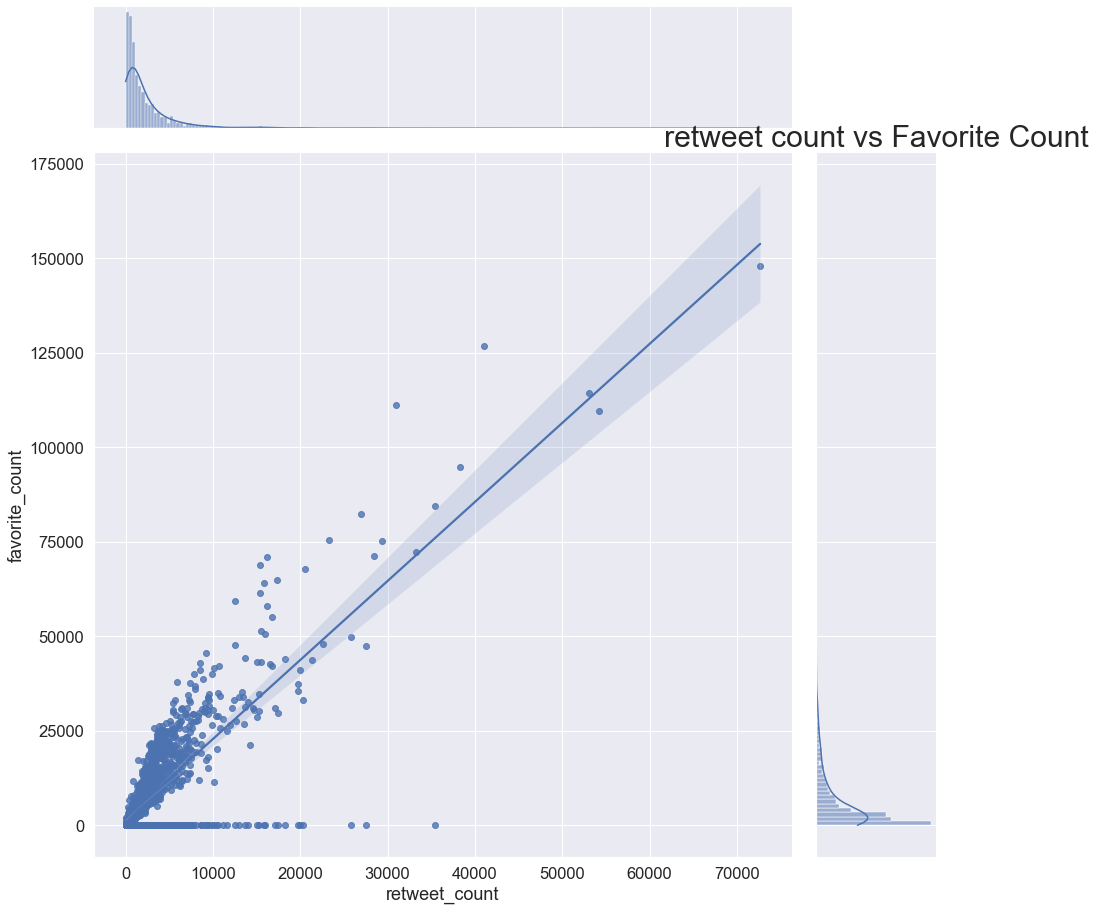

In [136]:
lm = sns.jointplot(x="retweet_count", y="favorite_count", data=dfs, kind="reg", height=13)

# Change the size of x and y lables.
import seaborn as sborn
sborn.set(font_scale=1.5)

ax = plt.gca()
ax.set_xlabel('Retweet Count')
ax.set_ylabel('Favorite Count')
ax.set_title("retweet count vs Favorite Count", fontsize=30);

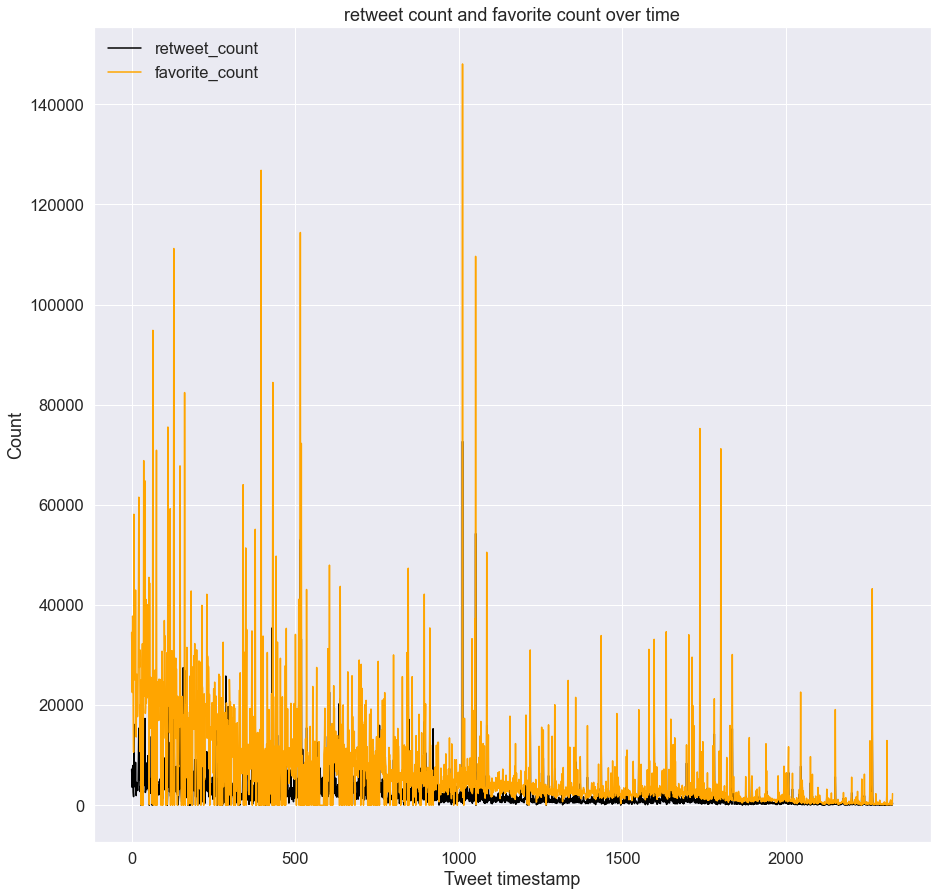

In [137]:
dfs['retweet_count'].plot(color = 'black', label='retweet_count')
dfs['favorite_count'].plot(color = 'Orange', label='favorite_count')
plt.style.use('seaborn-darkgrid')
plt.legend(loc='upper left')
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('retweet count and favorite count over time')
plt.savefig('retweet_count.png')
plt.show()

- Brent has all the right to get mad (ratings getting higher with no specific reason)


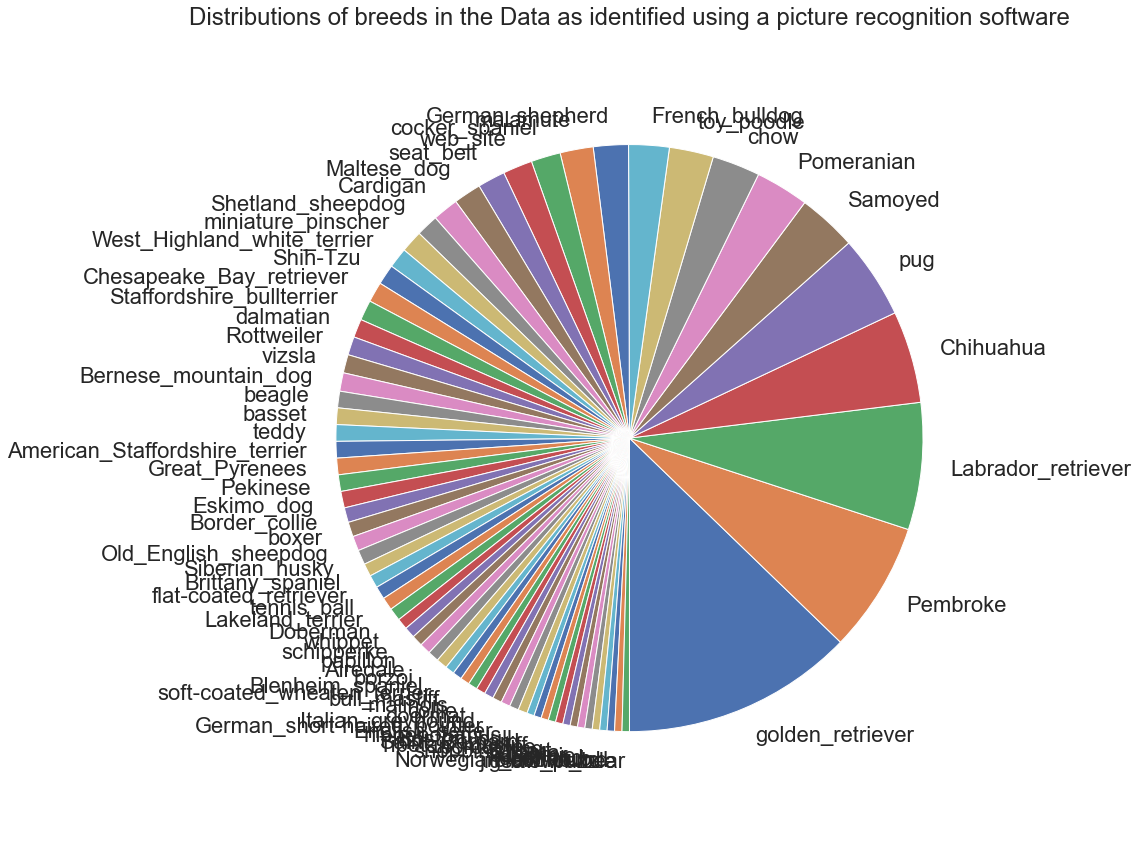

In [130]:
plt.rcParams['figure.figsize']=(15,15)

import matplotlib.pyplot as plt
dfs.Breed_probability1.value_counts(sort=True).plot.pie(startangle=270, pctdistance=0.8, radius = 0.9)
plt.title('Distributions of breeds in the Data as identified using a picture recognition software')
plt.ylabel('')
plt.show();

- Tweet Retweet Vs Favorites.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'retweet_count and favorite_count Scatter plot')

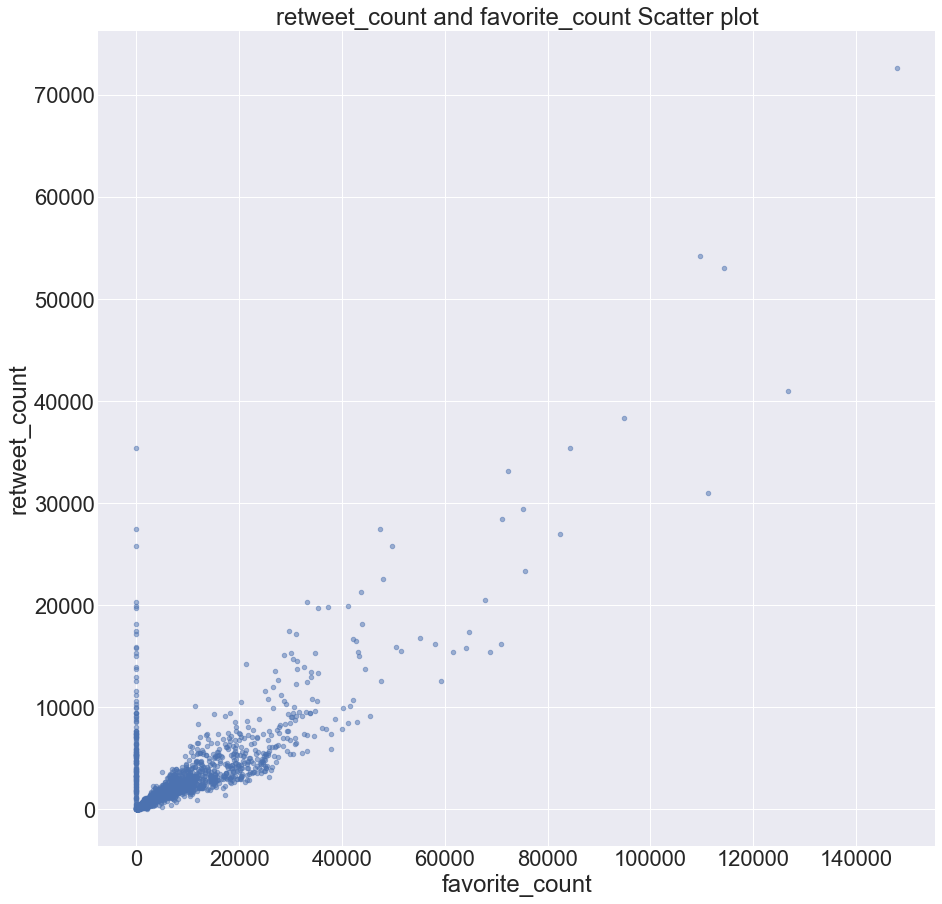

In [131]:
dfs.plot(kind='scatter',x='favorite_count',y='retweet_count', alpha = 0.5)
plt.xlabel('favorite_count')
plt.ylabel('retweet_count')
plt.title('retweet_count and favorite_count Scatter plot')

- As the correlation map shows that retweet is high correlated with favorites.


what Is there a relationship between ratings, favorite_count count and retweet_count?

Text(0.5, 1.0, 'Correlation Matrix')

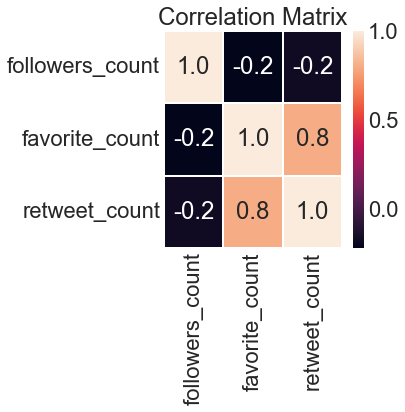

In [133]:
# Plotting the correlation map to investigate if there is a relationship

f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(dfs[['followers_count', 'favorite_count', 'retweet_count']].corr(), annot=True, linewidths=.4, fmt= '.1f')
plt.title('Correlation Matrix')

- Conclusion

The Twitter account @dog_rates is focused on rating and commenting humorously on pictures of dogs, hence the likes, retweets and ratings do not completely depend on the picture of the dogs since the humor affects the followers decision as well.
We believe we did a great job at this project, form gathering data to assessing it and cleaning it and then analyzing it. There were some problems though, for example, the missing tweet_ids that we couldn't scrape their data from Twitter. Also, the dataset definitely needs further cleaning and assessment
